# Application: Learning optimal restrictions in a continuous-action game

This notebook corresponds to Section 5.1 of the paper "Grams & Oesterle (forthcoming). _DRAMA at the PettingZoo: Dynamically Restricted Action Spaces for Multi-Agent Reinforcement Learning Frameworks_."

## Setup

In [27]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [28]:
import os, sys
sys.path.append(f'{os.getcwd()}/../../')

In [29]:
from gymnasium.spaces import Box
import matplotlib

from src.wrapper import RestrictionWrapper
from src.restrictors import IntervalUnionActionSpace

from examples.utils import play
from examples.cournot.utils.env import NFGEnvironment
from examples.cournot.utils.agents import UnrestrictedCournotAgent, RestrictedCournotAgent
from examples.cournot.utils.restrictor import CournotRestrictor

## Definition of the Cournot Game

In [49]:
maximum_price = 120
cost = 12

price_space = Box(0, maximum_price)
observation_spaces = {'player_0': price_space, 'player_1': price_space}
action_spaces = {'player_0': price_space, 'player_1': price_space}
utilities = {
    'player_0': (lambda actions: -actions['player_0'] ** 2 - actions['player_0'] * actions['player_1'] + (maximum_price - cost) * actions['player_0']), 
    'player_1': (lambda actions: -actions['player_1'] ** 2 - actions['player_0'] * actions['player_1'] + (maximum_price - cost) * actions['player_1'])}

env = NFGEnvironment(observation_spaces, action_spaces, utilities, number_of_steps=100, render_mode='human')

## Test: Play without restrictions

In [50]:
policies = {'player_0': UnrestrictedCournotAgent(maximum_price, cost).act, 'player_1': UnrestrictedCournotAgent(maximum_price, cost).act}
trajectory = play(env, policies, max_iter=100, render_mode=None, record_trajectory=True)

agent
player_0    Axes(0.125,0.11;0.775x0.77)
player_1    Axes(0.125,0.11;0.775x0.77)
Name: reward, dtype: object

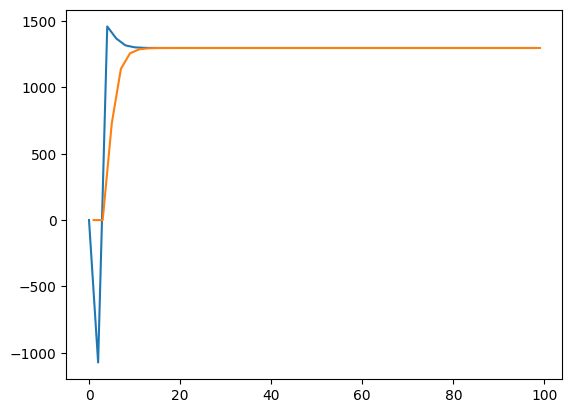

In [51]:
trajectory.groupby('agent')['reward'].plot()

## Self-learning restrictions

When we run the environment with the `CournotRestrictor`, we see that it observes the agents and waits until their strategies converge. At this point the restrictor estimates the environment parameters (more concretely, the parameter `lambda := maximum_price - cost`) from the observed agent actions, and defines a suitable restriction. The agents then react to the restriction by changing their strategies. Eventually, the restriction gives a reward increase by approximately 12.5%.

In [65]:
agents = [RestrictedCournotAgent(maximum_price, cost), RestrictedCournotAgent(maximum_price, cost)]
restrictor = CournotRestrictor(Box(0, maximum_price, shape=(2, )), IntervalUnionActionSpace(Box(0, maximum_price)))
wrapper = RestrictionWrapper(env, restrictor)

# Use restrictor for all agents uniformly
policies = {'player_0': agents[0].act, 'player_1': agents[1].act, 'restrictor_0': restrictor.act}

# Run wrapped environment for 100 iterations
trajectory = play(wrapper, policies, max_iter=100, render_mode=None, record_trajectory=True)

In [66]:
trajectory.head(20)

,agent,observation,reward,termination,truncation,info,action
0,restrictor_0,"[nan, nan]",0.000000,False,False,{},"IntervalUnionRestriction([(0.0, 26.99992063562..."
1,player_0,"{'observation': [None], 'restriction': Interva...",0.000000,False,False,{},8.260142
2,restrictor_0,"[8.260141942682125, nan]",0.000000,False,False,{},"IntervalUnionRestriction([(0.0, 26.99992063562..."
3,player_1,"{'observation': [8.260141942682125], 'restrict...",0.000000,False,False,{},49.869929
4,restrictor_0,"[8.260141942682125, 49.86992902865894]",0.000000,False,False,{},"IntervalUnionRestriction([(0.0, 26.99992063562..."
5,player_0,"{'observation': [49.86992902865894], 'restrict...",411.932692,False,False,{},29.065035
6,restrictor_0,"[29.06503548567053, nan]",8696.827541,False,False,{},"IntervalUnionRestriction([(0.0, 26.99992063562..."
7,player_1,"{'observation': [29.06503548567053], 'restrict...",2487.009821,False,False,{},39.467482
8,restrictor_0,"[29.06503548567053, 39.46748225716473]",2487.009821,False,False,{},"IntervalUnionRestriction([(0.0, 26.99992063562..."
9,player_0,"{'observation': [39.46748225716473], 'restrict...",1147.123772,False,False,{},34.266259


agent
player_0        Axes(0.125,0.11;0.775x0.77)
player_1        Axes(0.125,0.11;0.775x0.77)
restrictor_0    Axes(0.125,0.11;0.775x0.77)
Name: reward, dtype: object

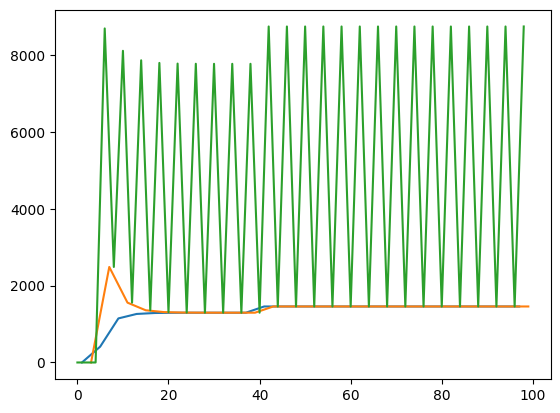

In [67]:
trajectory.groupby('agent')['reward'].plot()